In [13]:
import sys
import os
import math
import operator

sys.path.insert(0, os.path.abspath('..'))

# from autocnet import cuda
from autocnet.examples import get_path
from autocnet.graph.network import CandidateGraph
from autocnet.graph.edge import Edge
from autocnet.matcher.cpu_matcher import FlannMatcher
from autocnet.utils.utils import normalize_vector
from autocnet.matcher.deepen_funcs import dist_to_epipolar
from autocnet.camera.camera import compute_epipolar_line
from autocnet.control.control import ControlNetwork
import shapely.wkt as swkt
import geopandas as gpd
from scipy.spatial import KDTree

import networkx as nx
import pandas as pd
import random
from IPython.display import display

%pylab inline
figsize(20, 20)

Populating the interactive namespace from numpy and matplotlib


/scratch/anaconda3/envs/autocnet/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
#Point to the adjacency Graph
adjacency = get_path('cube_adjacency.json')
basepath = get_path('Apollo15')
cg = CandidateGraph.from_adjacency(adjacency, basepath=basepath)

#Apply SIFT to extract features
cg.extract_features(extractor_method='sift', extractor_parameters={'nfeatures':500})

#Match
cg.match()

#Apply outlier detection
cg.apply_func_to_edges(Edge.symmetry_check)
cg.apply_func_to_edges(Edge.ratio_check)
cg.compute_fundamental_matrices(clean_keys=['symmetry', 'ratio'])

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
cg.create_control_network(clean_keys = ['fundamental'])
print(cg.controlnetwork.data)

           point_id  image_index  keypoint_index        edge match_idx  \
measure_id                                                               
0                 0          0.0           425.0  (0.0, 1.0)         0   
1                 0          1.0             0.0  (0.0, 1.0)         0   
2                 1          0.0           296.0  (0.0, 1.0)        14   
3                 1          1.0             7.0  (0.0, 1.0)        14   
4                 2          0.0             4.0  (0.0, 1.0)        16   
5                 2          1.0             8.0  (0.0, 1.0)        16   
6                 3          0.0             9.0  (0.0, 1.0)        18   
7                 3          1.0             9.0  (0.0, 1.0)        18   
8                 4          0.0             0.0  (0.0, 1.0)        32   
9                 4          1.0            16.0  (0.0, 1.0)        32   
10                5          0.0           175.0  (0.0, 1.0)        36   
11                5          1.0      

In [5]:
def match_index(kp, func, *args, **kwargs):
    return func(*args, **kwargs)

r = lambda: random.uniform(0.0, 1.0)
color = [r(), r(), r()]

In [6]:
# for edge in cm._cg.edges():
#     edge_ob = cm._cg.edge[edge[0]][edge[1]]
#     edge_ob.new_match = {}
edge_dict = {}
for n1 in cg.nodes():
    for n2 in cg.nodes():
        if n1 != n2:
            edge_dict[(n1, n2)] = {}
print(edge_dict)

{(0, 1): {}, (1, 2): {}, (2, 0): {}, (1, 0): {}, (0, 2): {}, (2, 1): {}}


In [7]:
def deepen_correspondences(cn, overlap=False):
    # Get the candidates that lie within the overlap as an innitial mask
    candidates = cg.identify_potential_overlaps(overlap=overlap)
    print(candidates)
    # Loop through the candidates
    for i, j in enumerate(candidates):
        # Get the control point, "source", and keypoint for the candidate
        control_point = cg.controlnetwork.data.query('point_id == ' + str(candidates.index[i]))
        source = control_point.loc[control_point.index[0]].image_index
        kp = control_point.loc[control_point.index[0]].keypoint_index
        # Loop over all potential images that should overlap
        for destination in j:
            # Create an edge based off of source and destination
            edge = cg.edge[source][destination]
            # Current issue is given a source of 1 and a destination of 0, getting an edge based on index will
            # result in the edge 0, 1. While this is the same edge, the "source" and "destination" will not be accurate
            if source < destination:
                kp_coords = edge.source.get_keypoint_coordinates(index = kp, homogeneous=True).values
                keypoints = edge.destination.get_keypoint_coordinates(homogeneous = True).values
                f_matrix = edge['fundamental_matrix'].T
            else:
                kp_coords = edge.destination.get_keypoint_coordinates(index = kp, homogeneous=True).values
                keypoints = edge.source.get_keypoint_coordinates(homogeneous = True).values
                f_matrix = edge['fundamental_matrix']
#             index = dist_to_epipolar(kps, compute_epipolar_line(kp_coords, f_matrix=f_matrix), geometric_threshold=2)
            index = match_index(kp_coords, dist_to_epipolar, keypoints, compute_epipolar_line(kp_coords, f_matrix), geometric_threshold = .01)
            coords = keypoints[index]
            print(source, destination)
            print(kp, index)
#             edge_dict[(source, destination)][kp] = index

def source_to_dest(kp, source, destination):
    source_latlon = source.geodata.pixel_to_latlon(kp[0], kp[1])
    return destination.geodata.latlon_to_pixel(source_latlon[0], source_latlon[1])
    
def dest_to_source(kp, source, destination):
    dest_latlon = destination.geodata.pixel_to_latlon(kp[0], kp[1])
    return source.geodata.latlon_to_pixel(dest_latlon[0], dest_latlon[1])

In [8]:
def get_x(y, m, b):
    return (m/y) - b

def get_y(x, m, b):
    return (m*x) + b

In [9]:
deepen_correspondences(cg, overlap=True)

0      (2,)
1      (2,)
2      (2,)
3      (2,)
4      (2,)
5      (2,)
7      (2,)
8      (2,)
9      (2,)
11     (2,)
12     (2,)
13     (2,)
16     (2,)
17     (2,)
18     (2,)
19     (2,)
20     (2,)
21     (2,)
23     (2,)
25     (2,)
28     (2,)
30     (2,)
31     (2,)
38     (2,)
41     (2,)
43     (2,)
45     (2,)
46     (2,)
47     (2,)
48     (2,)
49     (2,)
50     (2,)
57     (1,)
61     (1,)
72     (1,)
74     (1,)
90     (1,)
91     (1,)
92     (1,)
96     (1,)
97     (1,)
98     (1,)
100    (1,)
104    (0,)
106    (0,)
107    (0,)
108    (0,)
110    (0,)
111    (0,)
113    (0,)
114    (0,)
Name: candidates, dtype: object
0.0 2
425.0 [ 61  83  84 160 163 350 424 427 451]
0.0 2
296.0 [252 257 327 343 344]
0.0 2
4.0 [ 87 142 143 208 209 211 212 214 216 225 247 299 346 363 481]
0.0 2
9.0

/home/acpaquette/autocnet/autocnet/graph/node.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  keypoints['homogeneous'] = 1


 [196 198]
0.0 2
0.0 [152 153 175 176 179 188 189 191 276 342 367 398 410 452 482]
0.0 2
175.0 [113 114 115 330 380]
0.0 2
15.0 [243 336]
0.0 2
176.0 [243 336]
0.0 2
16.0 [121 232 234 249 293]
0.0 2
74.0 [119 352]
0.0 2
355.0 [240 245 292]
0.0 2
457.0 [ 98  99 144 230 235 440 443]
0.0 2
68.0 [ 62  68  72 483]
0.0 2
179.0 [ 59  60 129 384]
0.0 2
310.0 [139 140 197 213 358 404 405 462 464 465]
0.0 2
311.0 [139 140 197 213 358 404 405 462 464 465]
0.0 2
85.0 [119 352]
0.0 2
406.0 [ 73  74  78  79  81 146 155 300 359 435 475]
0.0 2
198.0 [ 56  57 102 170 260 345 387 394 402 442 469 491]
0.0 2
259.0 [217 218 233 306 328]
0.0 2
246.0 [133 134 135 334 369 439 444]
0.0 2
329.0 [199 378 393 409 497]
0.0 2
5.0 [199 378 393 409 497]
0.0 2
375.0 [166 351 361 488]
0.0 2
443.0 [112 220 265 289 399 456 457 458 495 498]
0.0 2
463.0 [377 395 401 460]
0.0 2
446.0 [ 56  57 102 170 260 345 387 394 402 442 469 491]
0.0 2
350.0 [141 205 255 376 381 388 390 403]
0.0 2
316.0 [141 205 255 376 381 388 390 403]


[[ 311.26791382  476.34191895]
 [ 285.62652588  475.43603516]
 [ 288.91690063  474.50152588]
 [ 441.06500244  459.79501343]
 [ 441.06500244  459.79501343]
 [ 449.79730225  463.88699341]
 [ 449.79730225  463.88699341]
 [ 278.26358032  476.79067993]
 [ 278.26358032  476.79067993]
 [ 201.94970703  483.36599731]
 [ 406.67892456  466.53704834]
 [ 293.33319092  475.31845093]
 [ 287.94293213  480.67279053]
 [ 410.07925415  466.40136719]
 [ 209.81838989  481.6730957 ]]
['__add__', '__class__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'count', 'index']


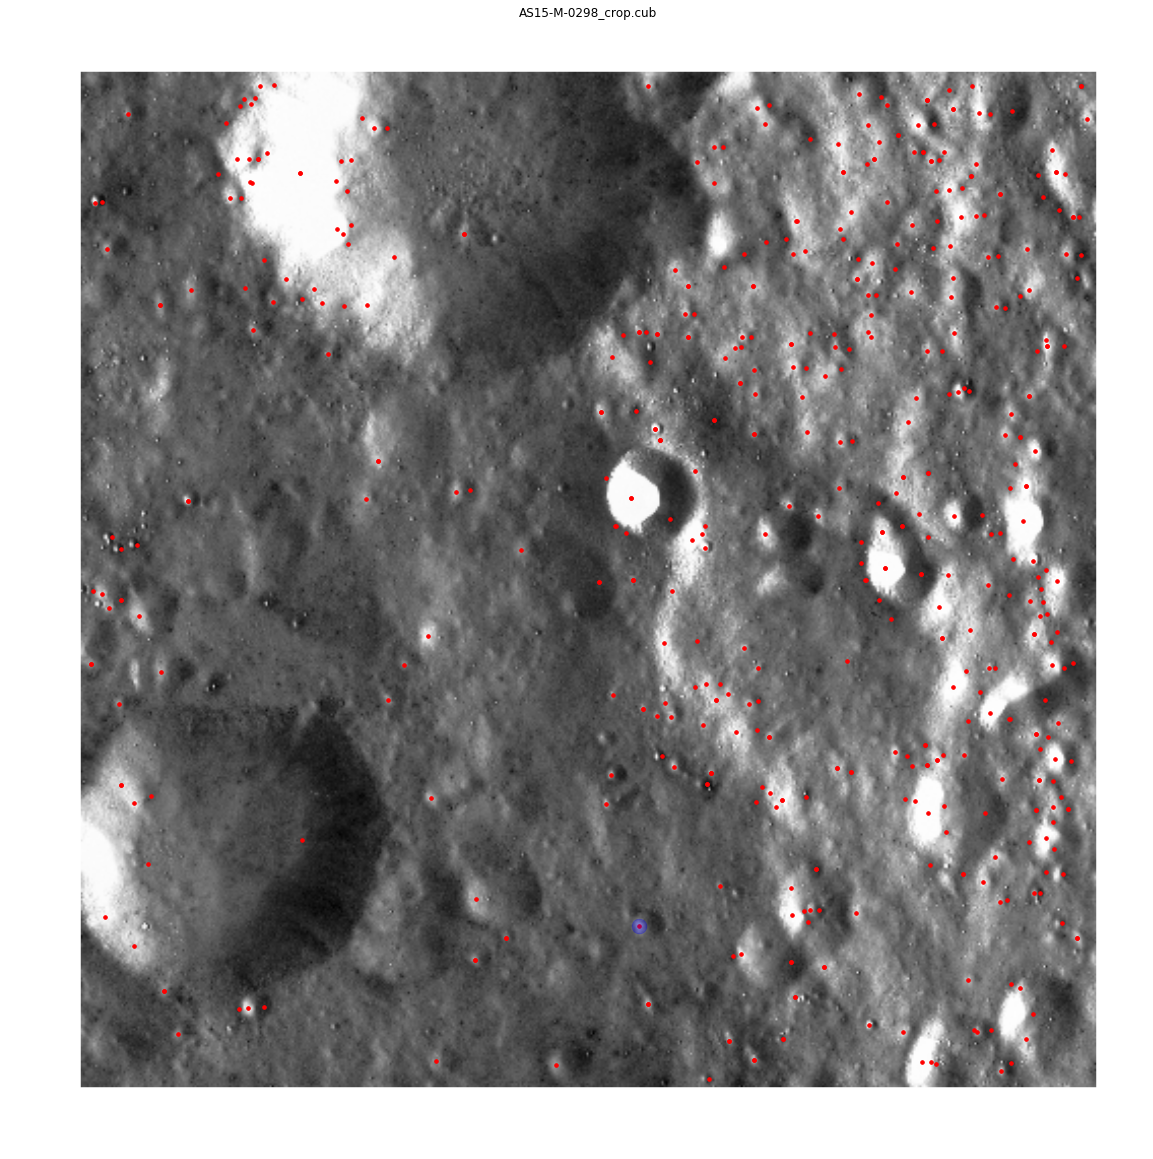

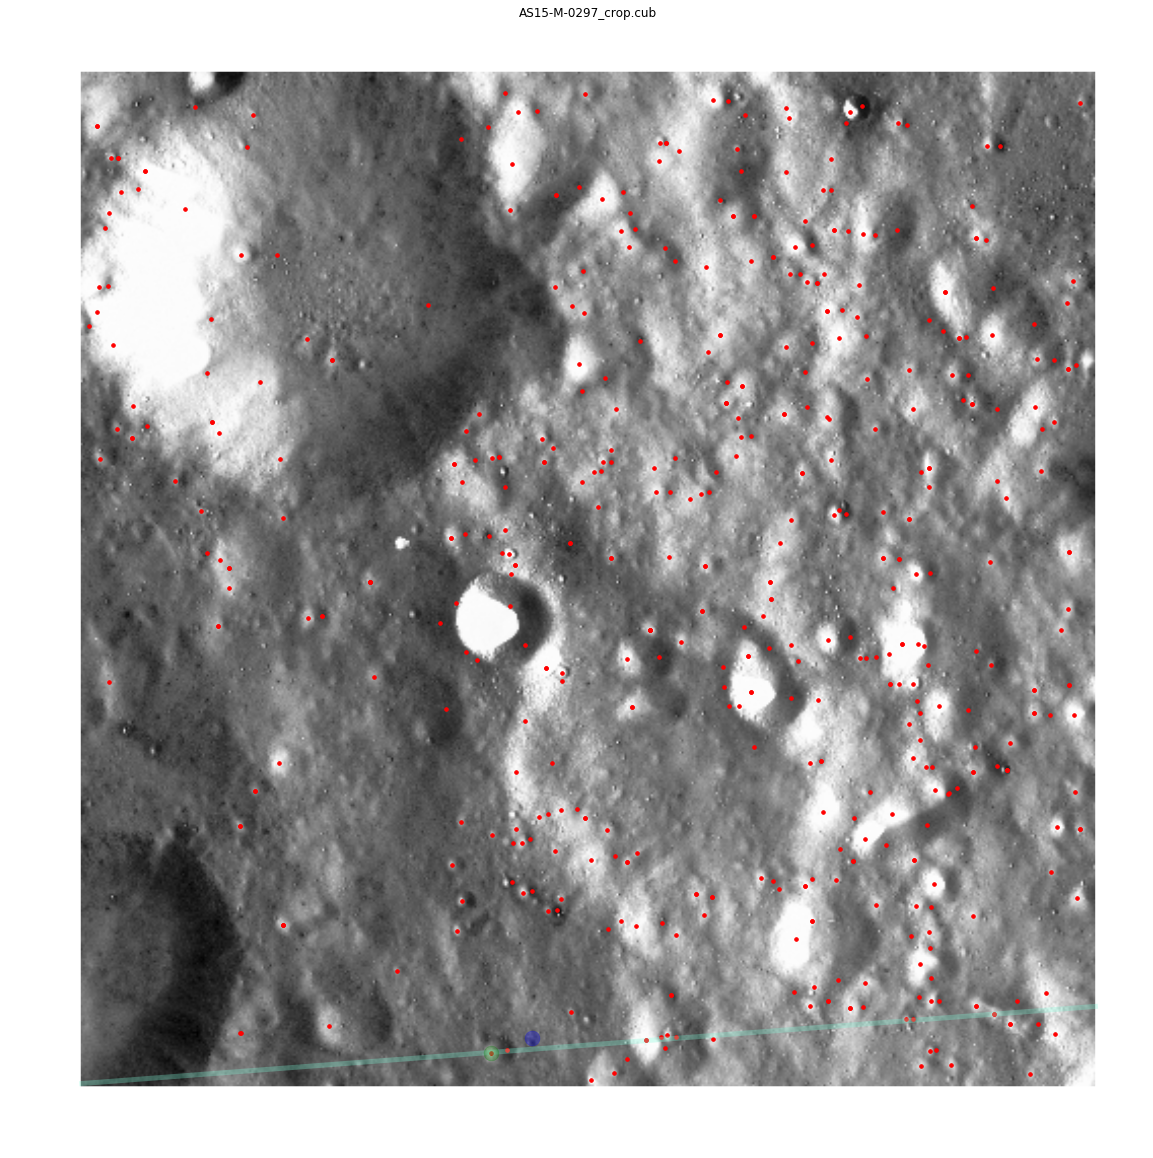

In [72]:
edge = cg.edge[0][2]
s_i = [4]
d_i = [87, 142, 143, 208, 209, 211 ,212, 214, 216, 225, 247, 299, 346, 363, 481]
keypoint = edge.source.get_keypoint_coordinates(index = s_i, homogeneous = True).values
reproj_keypoint = source_to_dest(keypoint[0], edge.source, edge.destination)
f_matrix = edge['fundamental_matrix'].T
e_line = compute_epipolar_line(keypoint[0], f_matrix=f_matrix)
m=(-(e_line[0]/e_line[1]))
b=(-(e_line[2]/e_line[1]))
distance_list = {}

kd_tree = KDTree(data = edge.destination.get_keypoint_coordinates(index = d_i))
print(kd_tree.data)
nearest_neighbors = kd_tree.query(reproj_keypoint, 2)
print(dir(nearest_neighbors))
d_i = d_i[nearest_neighbors[1][1]]
        
plt.figure(1)
edge.source.plot(clean_keys = 'fundamental', s = 50)
plot(edge.source.get_keypoint_coordinates().loc[s_i].x, edge.source.get_keypoint_coordinates().loc[s_i].y, 
     markersize = 30, marker = '.', alpha = .3, linewidth = 0)

plt.figure(2)
plot([0, 500], [get_y(0, m, b), get_y(500, m, b)], color = color, linewidth = 5, alpha = .3)
plot(reproj_keypoint[0], reproj_keypoint[1], 
     markersize = 30, marker = '.', alpha = .3, linewidth = 0)
edge.destination.plot(clean_keys = 'fundamental', s = 50)
plot(edge.destination.get_keypoint_coordinates().loc[d_i].x, 
     edge.destination.get_keypoint_coordinates().loc[d_i].y,
     markersize = 30, marker = '.', alpha = .3, linewidth = 0)

In [ ]:
# for i, edge in enumerate(cm._cg.edges()):
#     print(edge)
#     edge_ob = cm._cg.edge[edge[0]][edge[1]]
#     print(edge_ob.new_match)

In [ ]:
edge = cg.edge[0][2]
matches, mask = edge.clean(clean_keys = ['fundamental'])
# print(matches)
keypoints_list = []
e_keypoint_list = []
distance_list = []
m_list = []
b_list = []
for i in edge_dict[(0, 1)]:
    print(i)
    e_keypoint = cg.node[0].get_keypoint_coordinates(index = i, homogeneous = True).values
    e_keypoint_list.append(e_keypoint)

    f_matrix = edge['fundamental_matrix']
    
    e_line = compute_epipolar_line(e_keypoint, f_matrix=f_matrix)
    
    keypoints = cg.node[1].get_keypoint_coordinates(index = edge_dict[(0, 1)][i], homogeneous=True).values.T

    distance = np.abs(e_line.dot(keypoints))

    keypoints_list.append(keypoints)
    distance_list.append(distance)

    m_list.append(-(e_line[0]/e_line[1]))
    b_list.append(-(e_line[2]/e_line[1]))
    
plt.figure(1)
cg.node[1].plot(clean_keys = ['fundamental'])
j = 0
for i in keypoints_list:
    plt.figure(1)
    r = lambda: random.uniform(0.0, 1.0)
    color = [r(), r(), r()]
    plot(i[0], i[1], marker = '.', color = color, markersize = 25)
    plot([0, 500], [get_y(0, m_list[j], b_list[j]), get_y(500, m_list[j], b_list[j])], color = color, linewidth = 5)
    plt.figure(2)
    edge.plot_source(clean_keys = ['fundamental'])
    plot(e_keypoint_list[j][0], e_keypoint_list[j][1], color = color, markersize = 25, linewidth = 0, marker = '.')
    j += 1

In [ ]:
cg.compute_overlaps()
cg.overlap_checks()
matches, mask = cg.edge[0][1].clean(clean_keys = ['overlap'])
print(matches.head(20))
matches, mask = cg.edge[0][1].clean(clean_keys = ['fundamental'])
print(matches.head(10))

In [ ]:
edge = cg.edge[0][1]
kp = edge.destination.get_keypoint_coordinates(homogeneous=True).loc[8]
kps = edge.source.get_keypoint_coordinates(homogeneous = True).values
f_matrix = edge['fundamental_matrix'].T
index = add_point(kp, kps, dist_to_epipolar, compute_epipolar_line(f_matrix, kp), geometric_threshold = .2)
coords = kps[index]
print(coords)
# print(edge.source.get_keypoint_coordinates().loc[36])

In [ ]:
latlon_coords = edge.destination.geodata.pixel_to_latlon(edge.destination.get_keypoint_coordinates().loc[1].x,
                                                         edge.destination.get_keypoint_coordinates().loc[1].y)
print(edge.source.geodata.latlon_to_pixel(latlon_coords[0], latlon_coords[1]))
print(edge.source.get_keypoint_coordinates().loc[2])

In [ ]:
plt.figure(1)
edge.source.plot(clean_keys = 'fundamental', s = 50)
ax = plt.gca()
ax.scatter(coords.T[0], coords.T[1], s = 400, marker = '.', alpha = .5, color='b')
# plot(edge.source.get_keypoint_coordinates().loc[36].x, edge.source.get_keypoint_coordinates().loc[36].y)
plt.figure(2)
edge.destination.plot(clean_keys = 'fundamental', s = 50)
plot(edge.destination.get_keypoint_coordinates().loc[8].x, edge.destination.get_keypoint_coordinates().loc[8].y,
     markersize = 30, marker = '.', alpha = .5)

In [ ]:
# def deepen_correspondences(node, bc, keypoint_idx,
#                            clean_keys=[],
#                            geometric_threshold=2):

#     # Grab F for reprojection
#     f_matrix = bc['fundamental_matrix']

#     if f_matrix is None:
#         return None, None

#     # Compute the epipolar line projecting point ab into bc
#     ab_kp = node.get_keypoint_coordinates(homogeneous = True).loc[keypoint_idx]
#     epipolar_line = normalize_vector(ab_kp.dot(f_matrix.T))

#     # Check to see if a previously removed candidate fulfills the threshold geometric constraint
#     if node['node_id'] == edge.source['node_id']:
#         bc_candidates = bc.matches[(bc.matches['source_idx'] == keypoint_idx)]
#         bc_candidate_coords = bc.destination.get_keypoint_coordinates(index=bc_candidates['destination_idx'], 
#                                                                       homogeneous = True).values
# #         bc_candidate_coords = bc.destination.get_keypoint_coordinates(homogeneous = True).values
#     else:
#         bc_candidates = bc.matches[(bc.matches['destination_idx'] == keypoint_idx)]
#         bc_candidate_coords = bc.source.get_keypoint_coordinates(index=bc_candidates['source_idx'], 
#                                                                       homogeneous = True).values
# #         bc_candidate_coords = bc.source.get_keypoint_coordinates(homogeneous = True).values
    
#     bc_distance = np.abs(epipolar_line.dot(bc_candidate_coords.T))

#     # Get the matches
#     second_order_candidates = np.where(bc_distance < geometric_threshold)[0]

#     # In testing, every single valid second order candidate has a single, duplicated entry.
#     # That is, the correspondence has passed symmetry, but failed some other check.  Therefore,
#     # an additional descriptor distance check is omitted here.
#     if len(second_order_candidates) > 0:
#         coord_list = []
#         for i in second_order_candidates:
# #             new_match = bc_candidates.iloc[second_order_candidates[0]]
#             coord_list.append(bc_candidate_coords[i])
#         return coord_list
#     else:
#         return None, None